In [16]:
!git clone https://github.com/damianlacz/AudioMNIST-recon-gan.git

directory_path = "/content/AudioMNIST-recon-gan/data/"
generator_path = "/content/AudioMNIST-recon-gan/custom_models/gen.keras"
discriminator_path = "/content/AudioMNIST-recon-gan/custom_models/disc.keras"
load_model = False

fatal: destination path 'AudioMNIST-recon' already exists and is not an empty directory.


In [17]:
import sys
sys.path.insert(0, "/content/AudioMNIST-recon-gan/")

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr

def load_stfts(directory_path, max_files = 15000):

    specs = []
    spec_paths = glob.glob(os.path.join(directory_path, '*.npy'))
    spec_paths = spec_paths[:max_files]
    specs += [np.load(path) for path in spec_paths]

    return np.array(specs)

def normalize_specs(data, type = 'standardization'):
    if type == 'standardization':
        return np.array([(x - x.mean()) / x.std() for x in data])
    if type == 'minmax':
        return np.array([(x - x.min()) / (x.max() - x.min()) for x in data])
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])
    if type == 'max':
        return np.array([x / np.max(np.abs(x)) for x in data])

In [19]:
def build_generator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    z = tf.keras.layers.BatchNormalization()(input_layer)
    z = tf.keras.layers.Dense(64 * 29 * 1, use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Reshape(target_shape = (64, 29, 1))(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (2, 7), strides = (2, 1), use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (2, 7), strides = (2, 1), use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (2, 7), strides = (2, 2), padding = 'valid', use_bias = False, activation='relu')(z)
    return tf.keras.Model(input_layer, z, name = 'generator')

def build_discriminator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(input_layer)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (3, 3), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, use_bias = True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(1, use_bias = True, activity_regularizer=tf.keras.regularizers.L1(0.1))(x)
    return tf.keras.Model(input_layer, x, name = 'discriminator')

In [20]:
batch_size = 16

generator_input_shape = (batch_size, 512, )
discriminator_input_shape = (batch_size, 512, 87, 1)

generator = build_generator(generator_input_shape)
discriminator = build_discriminator(discriminator_input_shape)

In [21]:
from sklearn.model_selection import train_test_split

stfts = load_stfts(directory_path)

X_train, X_test, _, _ = train_test_split(stfts, np.random.rand(stfts.shape[0],), random_state= 12, shuffle = True, test_size = 0.25)
X_train  = normalize_specs(X_train.reshape(*X_train.shape, 1), type = 'minmax')
X_test = normalize_specs(X_test.reshape(*X_test.shape, 1), type = 'minmax')

In [23]:
from tensorflow.keras.losses import BinaryCrossentropy

class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()

        self.generator = generator
        self.discriminator = discriminator
        self.binary_cross_entropy = BinaryCrossentropy(from_logits = True)

        self.real_loss_noise_weight = 1
        self.real_loss_weight = 1024
        self.fake_loss_noise_weight = 1
        self.fake_loss_weight = 1024

        self.gen_opt = tf.keras.optimizers.Adam(1e-4)
        self.disc_opt = tf.keras.optimizers.Adam(2e-5)

    def compute_loss(self, inputs):
        noise = tf.random.normal(shape = (batch_size, 512, 1))
        fake_result = self.discriminator(self.generator(noise, training = True), training = True)
        real_result = self.discriminator(inputs, training = True)

        real = tf.ones_like(real_result) - self.real_loss_noise_weight * tf.random.normal(shape = tf.shape(real_result))
        fake = tf.zeros_like(fake_result) + self.fake_loss_noise_weight * tf.random.normal(shape = tf.shape(fake_result))

        real_loss = self.real_loss_weight * self.binary_cross_entropy(real, real_result)
        fake_loss = self.fake_loss_weight * self.binary_cross_entropy(fake, fake_result)

        gen_loss = self.binary_cross_entropy(fake_result, tf.ones_like(fake_result))
        disc_loss = real_loss + fake_loss

        return gen_loss, disc_loss, real_loss, fake_loss

    def train_step(self, data):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_loss, disc_loss, real_loss, fake_loss = self.compute_loss(data)
        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.disc_opt.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss
        }


    def predict(self, x):
        self.generator(x, training = False)

In [24]:
gan = GAN(generator=generator, discriminator=discriminator)
gan.compile()

In [38]:
if not load_model:
  gan.fit(X_train, batch_size = batch_size, epochs = 500, shuffle = True)

261/704 [==========>...................] - ETA: 9:04 - gen_loss: 1.3124 - disc_loss: 1424.3937 - real_loss: 713.8035 - fake_loss: 710.5902

KeyboardInterrupt: 

In [27]:
if load_model:
    gan.generator.load_weights(filepath = generator_path)
    gan.discriminator.load_weights(filepath = discriminator_path)

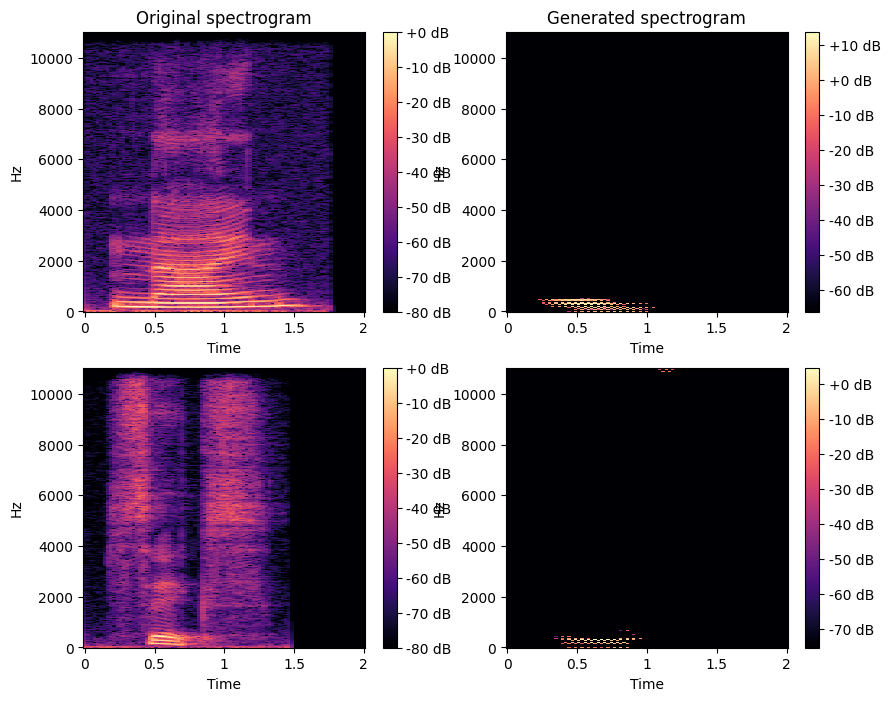

In [39]:
noise = tf.random.normal(shape = generator_input_shape)
generated = gan.generator(noise)
n = 2
fig, ax = plt.subplots(n, 2, figsize = (10, 4 * n))
ax[0][0].set(title = "Original spectrogram")
ax[0][1].set(title = "Generated spectrogram")

for i in range(n):
    img_original = librosa.display.specshow(librosa.amplitude_to_db((X_test[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][0])
    img_recon = librosa.display.specshow(librosa.amplitude_to_db(np.array(generated[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][1])
    fig.colorbar(img_original, ax = ax[i][0], format = "%+2.f dB", cmap = 'viridis')
    fig.colorbar(img_recon, ax = ax[i][1], format = "%+2.f dB")

In [40]:
from IPython.display import Audio

tf.random.set_seed(2222)
noise = tf.random.normal(shape = generator_input_shape)
generated = gan.generator(noise, training = False)

Audio(librosa.util.normalize(librosa.griffinlim(np.array(generated[2, :, :, 0]))), rate = 22050)